In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error,r2_score

In [ ]:
data = pd.read_csv('household_power_consumption.txt', delimiter=';',parse_dates={'dt':['Date','Time']},
                infer_datetime_format=True,
                low_memory=False, na_values=['nan','?'],
                index_col='dt')


In [ ]:
data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_n
dt,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000
...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,15.766667
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,15.733333
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,15.633333


In [ ]:
data2 = data.resample('20T').sum()
data2.sort_values('dt',ascending=True)
data2

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:20:00,70.046,7.512,3748.28,301.0,0.0,19.0,269.0
2006-12-16 17:40:00,81.978,0.732,4698.90,350.6,0.0,0.0,338.0
2006-12-16 18:00:00,82.464,2.546,4705.15,355.6,0.0,331.0,339.0
2006-12-16 18:20:00,70.836,0.452,4693.46,303.8,0.0,46.0,338.0
2006-12-16 18:40:00,64.632,1.804,4676.20,276.6,0.0,26.0,335.0
...,...,...,...,...,...,...,...
2010-10-15 10:20:00,30.962,2.666,4729.49,130.0,0.0,24.0,366.0
2010-10-15 10:40:00,38.584,7.256,4732.32,165.0,0.0,23.0,466.0
2010-10-15 11:00:00,38.536,9.348,4753.66,166.8,0.0,24.0,359.0


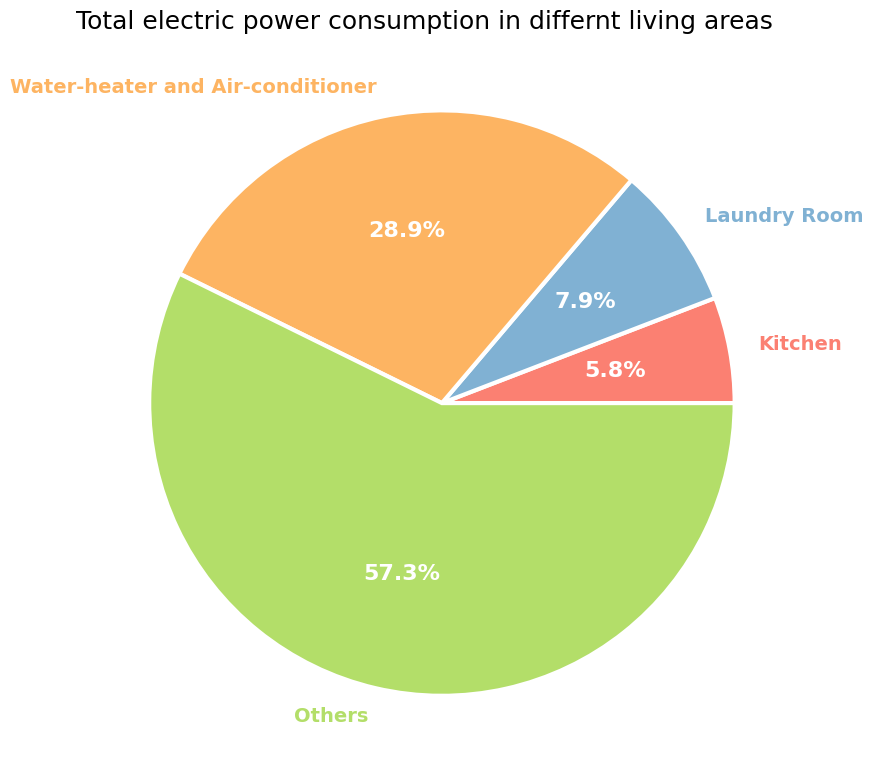

In [ ]:
cls = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_n']
pie_data = data[cls].sum(axis=0)
labels = ['Kitchen', 'Laundry Room', 'Water-heater and Air-conditioner', 'Others']

plt.figure(figsize=(9,9))
colors = sns.color_palette('Set3')[3:]
patches, texts, pcts = plt.pie(
                            pie_data, labels=labels, 
                            colors=colors,
                            autopct='%.1f%%',
                            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
                            startangle=0
)

for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white', fontsize=16, fontweight='bold')
plt.setp(texts, fontsize=14, fontweight='bold')
plt.title('Total electric power consumption in differnt living areas', fontsize=18, loc='left')
plt.tight_layout()

##From the chart above we can see about half of the electric power is consumed in living areas other than the kitchen, laundry room or water-heater and air-conditioner, where the electric power consumption of air-conditioner and water-heater accounts for 28.9% of the total consumption. The kitchen and laundry room account for 13% of the total.

In [ ]:
def make_plot(x,y,y_label):
  plt.figure(figsize=(15,6), dpi=60)
  plt.plot(x,y)
  plt.ylabel(y_label)
  plt.show()

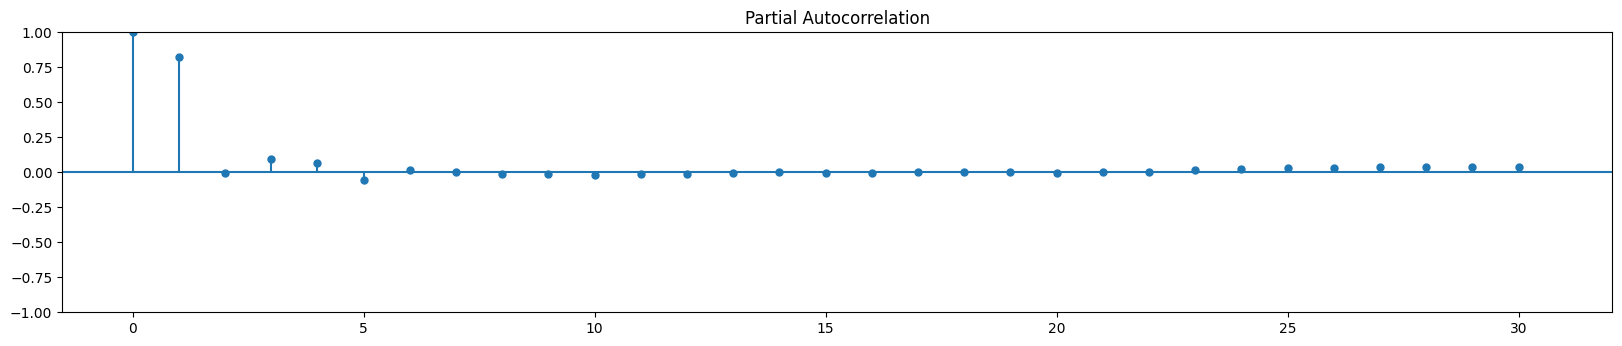

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(data2['Global_active_power'], alpha=.05,lags=30,ax=ax1, method='ywm')

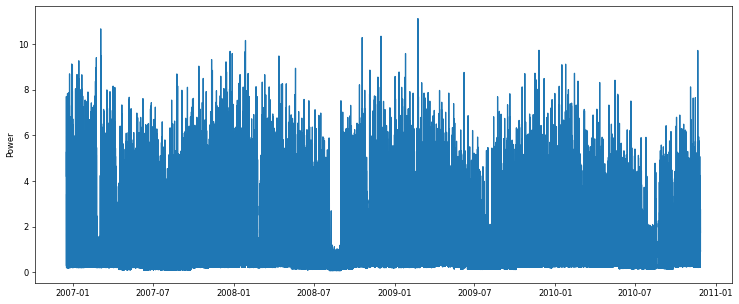

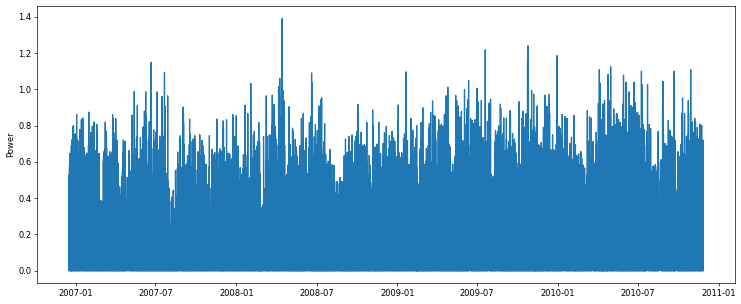

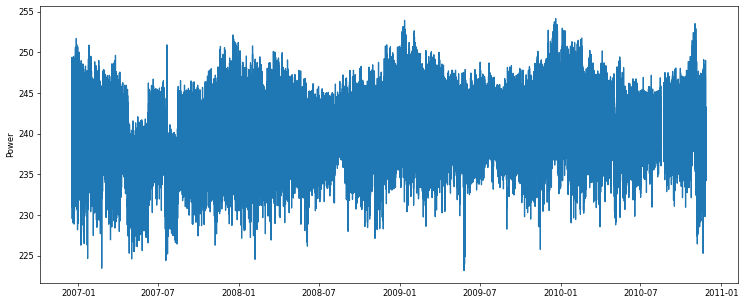

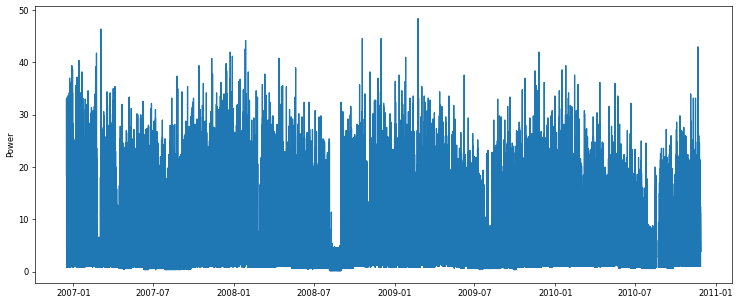

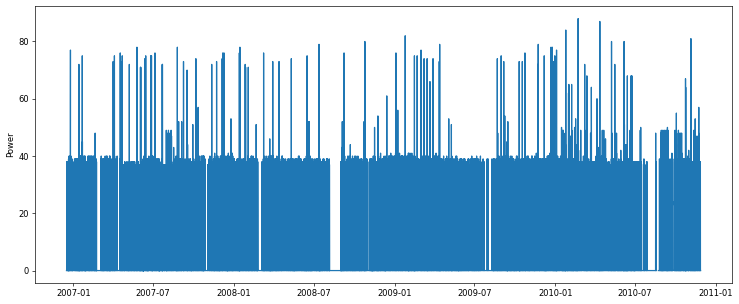

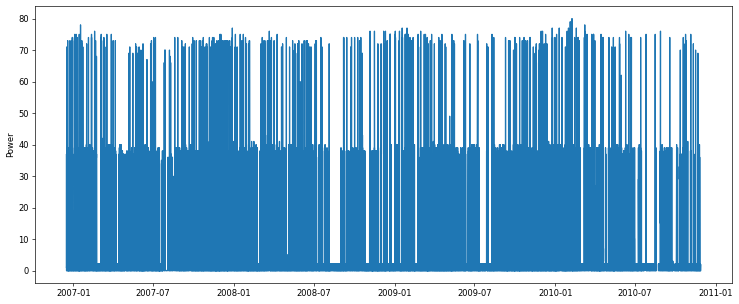

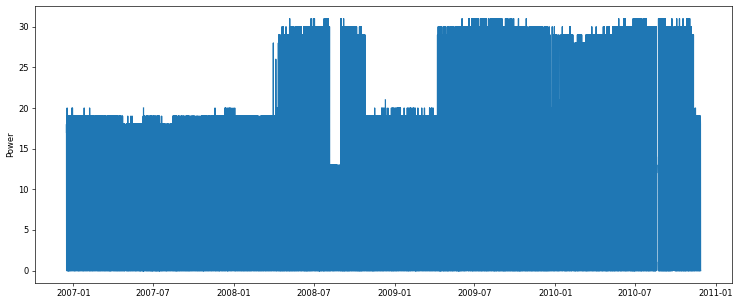

In [ ]:
make_plot(data.index, data['Global_active_power'], 'Power')
make_plot(data.index, data['Global_reactive_power'], 'Power')
make_plot(data.index, data['Voltage'], 'Power')
make_plot(data.index, data['Global_intensity'], 'Power')
make_plot(data.index, data['Sub_metering_1'], 'Power')
make_plot(data.index, data['Sub_metering_2'], 'Power')
make_plot(data.index, data['Sub_metering_3'], 'Power')

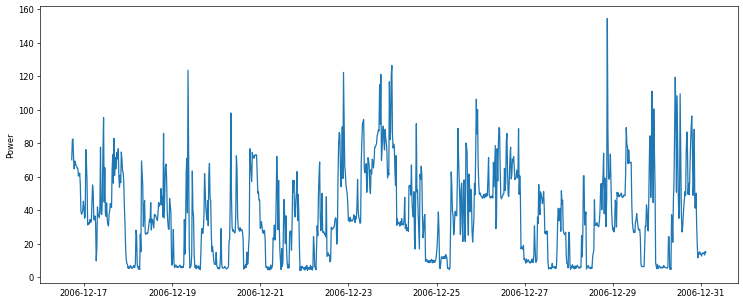

In [ ]:
n = len(data2['Global_active_power'])
s = int(n/100)
s1 = data2['Global_active_power']
plt.figure(figsize=(15,6), dpi=60)
plt.plot(s1[:s])
plt.ylabel('Power')
plt.show()

In [ ]:
TIME, SERIES = data2.index[:], data2['Global_active_power']
SPLIT_TIME = 1100 # on day 1100 the training period will end. The rest will belong to the validation set
WINDOW_SIZE = 6 # how many data points will we take into account to make our prediction
BATCH_SIZE = 32 # how many items will we supply per batch
SHUFFLE_BUFFER_SIZE = 1000 # we need this parameter to define the Tensorflow sample buffer

In [ ]:
# test for stationarity
from statsmodels.tsa.stattools import adfuller
result_test_data = adfuller(data2['Global_active_power'])
def adfuller_test(series):
    result = adfuller(series)
    label_list = ['F-test','P-value','Lags','Number of observations']
    for value,label in zip(result,label_list):
        print(label + ':' + str(value))
    if result[1] <=0.05:
        print('we reject the H0,we accept H1')
    else:
        print('we cannot reject H0, we need accept H0')

adfuller_test(data2['Global_active_power'])

F-test:-18.597780787446347
P-value:2.0705791803308242e-30
Lags:69
Number of observations:103694
we reject the H0,we accept H1


In [ ]:
def train_val_split(time, series, time_step=SPLIT_TIME):
	"""Divide the time series into training and validation set"""
	time_train = time[:time_step]
	series_train = series[:time_step]
	time_valid = time[time_step:]
	series_valid = series[time_step:]

	return time_train, series_train, time_valid, series_valid

def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER_SIZE):
	"""
	We create time windows to create X and y features.
	For example, if we choose a window of 30, we will create a dataset formed by 30 points as X
	"""
	dataset = tf.data.Dataset.from_tensor_slices(series)
	dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
	dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
	dataset = dataset.shuffle(shuffle_buffer)
	dataset = dataset.map(lambda window: (window[:-1], window[-1]))
	dataset = dataset.batch(batch_size).prefetch(1)
	return dataset

In [ ]:
dataset = windowed_dataset(series_train)
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)



In [ ]:
def create_uncompiled_model():
  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                    input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(1),
  ]) 

  return model

In [ ]:
class EarlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    
    if(logs.get('mae') < 0.9):
      print("\nMAEthreshold reached. Training stopped.")
      self.model.stop_training = True

early_stopping = EarlyStopping()

In [ ]:
# very slow took 28 hours still didnt converge after 200 epochs
def create_model():
    tf.random.set_seed(1)
  
    model = create_uncompiled_model()
  
    model.compile(loss=tf.keras.losses.Huber(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=[["mae", "mape", "mse"]])  
    return model
  
model = create_model()

history = model.fit(dataset, epochs=200, callbacks=[early_stopping])

Epoch 1/200
34/34 [==============================] - 699s 18s/step - loss: 1539.8182 - mae: 1540.3182 - mape: 22406236.0000 - mse: 2749865.5000
Epoch 2/200
34/34 [==============================] - 467s 14s/step - loss: 1532.2295 - mae: 1532.7295 - mape: 36336112.0000 - mse: 2726587.7500
Epoch 3/200
34/34 [==============================] - 468s 14s/step - loss: 1527.4797 - mae: 1527.9797 - mape: 45049524.0000 - mse: 2711928.7500
Epoch 4/200
34/34 [==============================] - 470s 14s/step - loss: 1522.9009 - mae: 1523.4009 - mape: 52365800.0000 - mse: 2697853.2500
Epoch 5/200
34/34 [==============================] - 458s 13s/step - loss: 1518.4047 - mae: 1518.9047 - mape: 63490320.0000 - mse: 2684194.7500
Epoch 6/200
34/34 [==============================] - 987s 29s/step - loss: 1513.9462 - mae: 1514.4462 - mape: 73031968.0000 - mse: 2670615.2500
Epoch 7/200
34/34 [==============================] - 1007s 29s/step - loss: 1509.5150 - mae: 1510.0150 - mape: 80324744.0000 - mse: 2657

34/34 [==============================] - 570s 16s/step - loss: 1063.3101 - mae: 1063.8101 - mape: 934110272.0000 - mse: 1477956.2500
Epoch 114/200
34/34 [==============================] - 529s 16s/step - loss: 1059.4083 - mae: 1059.9082 - mape: 938952896.0000 - mse: 1469024.7500
Epoch 115/200
34/34 [==============================] - 589s 17s/step - loss: 1055.5414 - mae: 1056.0414 - mape: 946919488.0000 - mse: 1460156.3750
Epoch 116/200
34/34 [==============================] - 580s 17s/step - loss: 1051.7139 - mae: 1052.2136 - mape: 955392832.0000 - mse: 1451528.0000
Epoch 117/200
34/34 [==============================] - 674s 20s/step - loss: 1047.9220 - mae: 1048.4220 - mape: 967403328.0000 - mse: 1442897.3750
Epoch 118/200
34/34 [==============================] - 507s 15s/step - loss: 1044.1497 - mae: 1044.6495 - mape: 973729152.0000 - mse: 1434271.7500
Epoch 119/200
34/34 [==============================] - 569s 17s/step - loss: 1040.3979 - mae: 1040.8979 - mape: 979145600.0000 - mse

34/34 [==============================] - 463s 14s/step - loss: 859.3669 - mae: 859.8669 - mape: 1367039232.0000 - mse: 1041072.6875
Epoch 170/200
34/34 [==============================] - 458s 13s/step - loss: 855.9114 - mae: 856.4114 - mape: 1372235008.0000 - mse: 1034374.8750
Epoch 171/200
34/34 [==============================] - 554s 16s/step - loss: 852.4330 - mae: 852.9330 - mape: 1380653440.0000 - mse: 1027557.1875
Epoch 172/200
34/34 [==============================] - 486s 14s/step - loss: 849.0058 - mae: 849.5057 - mape: 1390853504.0000 - mse: 1020999.8125
Epoch 173/200
34/34 [==============================] - 470s 14s/step - loss: 845.5865 - mae: 846.0862 - mape: 1400075136.0000 - mse: 1014326.3750
Epoch 174/200
34/34 [==============================] - 465s 14s/step - loss: 842.1875 - mae: 842.6875 - mape: 1406258176.0000 - mse: 1007731.4375
Epoch 175/200
34/34 [==============================] - 480s 14s/step - loss: 838.7912 - mae: 839.2912 - mape: 1413509248.0000 - mse: 10012

*This* programme trains an LSTM model on residential electricity power use data. The Adam optimizer's learning rate of 0.005 has been changed in the create_model method. The old code used 0.001.

Updated model, dataset, and early stopping callback are passed to model.fit. The epochs parameter is 200, therefore the training will last 200 epochs or until the early termination threshold is fulfilled. History2 holds training history.

Increasing the learning rate may speed convergence but make training less stable. Thus, monitoring and adjusting the training rate is crucial.

In [ ]:
# increased learning rate
def create_model():
    tf.random.set_seed(2)
  
    model = create_uncompiled_model()
  
    model.compile(loss=tf.keras.losses.Huber(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  metrics=[["mae", "mape", "mse"]])  
    return model
  
model = create_model()

history2 = model.fit(dataset, epochs=200, callbacks=[early_stopping])

Epoch 1/200
34/34 [==============================] - 715s 18s/step - loss: 1531.0658 - mae: 1531.5658 - mape: 30157908.0000 - mse: 2722638.2500
Epoch 2/200
34/34 [==============================] - 597s 18s/step - loss: 1507.5253 - mae: 1508.0253 - mape: 80295960.0000 - mse: 2650987.5000
Epoch 3/200
34/34 [==============================] - 571s 17s/step - loss: 1485.4166 - mae: 1485.9166 - mape: 131924912.0000 - mse: 2583730.7500
Epoch 4/200
34/34 [==============================] - 560s 16s/step - loss: 1463.5625 - mae: 1464.0625 - mape: 178662912.0000 - mse: 2519505.7500
Epoch 5/200
34/34 [==============================] - 528s 16s/step - loss: 1441.8215 - mae: 1442.3215 - mape: 217922224.0000 - mse: 2455846.7500
Epoch 6/200
34/34 [==============================] - 522s 15s/step - loss: 1420.1484 - mae: 1420.6484 - mape: 235161136.0000 - mse: 2393325.7500
Epoch 7/200
34/34 [==============================] - 511s 15s/step - loss: 1398.5410 - mae: 1399.0410 - mape: 286809696.0000 - mse: 

34/34 [==============================] - 532s 16s/step - loss: 580.1538 - mae: 580.6537 - mape: 2097330688.0000 - mse: 557197.6250
Epoch 58/200
34/34 [==============================] - 529s 16s/step - loss: 572.4259 - mae: 572.9256 - mape: 2117738112.0000 - mse: 544832.0000
Epoch 59/200
34/34 [==============================] - 530s 16s/step - loss: 565.3175 - mae: 565.8170 - mape: 2143594752.0000 - mse: 533344.0000
Epoch 60/200
34/34 [==============================] - 534s 16s/step - loss: 558.6188 - mae: 559.1182 - mape: 2172725760.0000 - mse: 522791.0000
Epoch 61/200
34/34 [==============================] - 532s 16s/step - loss: 552.4004 - mae: 552.9004 - mape: 2191954688.0000 - mse: 513020.8125
Epoch 62/200
34/34 [==============================] - 531s 16s/step - loss: 546.3008 - mae: 546.8008 - mape: 2219085824.0000 - mse: 503345.9062
Epoch 63/200
34/34 [==============================] - 531s 16s/step - loss: 540.4734 - mae: 540.9734 - mape: 2243173120.0000 - mse: 494098.1562
Epoch

34/34 [==============================] - 428s 13s/step - loss: 470.4406 - mae: 470.9405 - mape: 2818011904.0000 - mse: 378608.3438
Epoch 114/200
34/34 [==============================] - 433s 13s/step - loss: 470.4344 - mae: 470.9343 - mape: 2819053824.0000 - mse: 378575.0938
Epoch 115/200
34/34 [==============================] - 430s 13s/step - loss: 470.4428 - mae: 470.9425 - mape: 2819557632.0000 - mse: 378543.3125
Epoch 116/200
34/34 [==============================] - 433s 13s/step - loss: 470.4184 - mae: 470.9182 - mape: 2822084096.0000 - mse: 378478.9062
Epoch 117/200
34/34 [==============================] - 432s 13s/step - loss: 470.4204 - mae: 470.9198 - mape: 2822219776.0000 - mse: 378470.6562
Epoch 118/200
34/34 [==============================] - 441s 13s/step - loss: 470.4256 - mae: 470.9256 - mape: 2823910400.0000 - mse: 378423.4062
Epoch 119/200
34/34 [==============================] - 469s 14s/step - loss: 470.4065 - mae: 470.9065 - mape: 2824798208.0000 - mse: 378373.2500

34/34 [==============================] - 833s 24s/step - loss: 470.3604 - mae: 470.8596 - mape: 2841548288.0000 - mse: 377967.1250
Epoch 170/200
34/34 [==============================] - 817s 24s/step - loss: 470.3652 - mae: 470.8643 - mape: 2842326784.0000 - mse: 377957.0312
Epoch 171/200
34/34 [==============================] - 840s 25s/step - loss: 470.4234 - mae: 470.9234 - mape: 2839210752.0000 - mse: 378099.3125
Epoch 172/200
34/34 [==============================] - 31798s 963s/step - loss: 470.3401 - mae: 470.8401 - mape: 2839756544.0000 - mse: 377968.9062
Epoch 173/200
34/34 [==============================] - 458s 13s/step - loss: 470.3596 - mae: 470.8589 - mape: 2844007168.0000 - mse: 377929.0625
Epoch 174/200
34/34 [==============================] - 451s 13s/step - loss: 470.3680 - mae: 470.8675 - mape: 2841882112.0000 - mse: 377960.7812
Epoch 175/200
34/34 [==============================] - 444s 13s/step - loss: 470.4209 - mae: 470.9209 - mape: 2845149696.0000 - mse: 377909.7

In [ ]:
# adjusted early stopping condition and learning rate reduced epochs, make a more simple model

def create_uncompiled_model():
  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                    input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6, return_sequences=True)),
      tf.keras.layers.Dense(1),
  ]) 

  return model

def create_model():
    tf.random.set_seed(3)
  
    model = create_uncompiled_model()
  
    model.compile(loss=tf.keras.losses.Huber(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.008),
                  metrics=[["mae", "mape", "mse"]])  
    return model

model = create_model()

history3 = model.fit(dataset, epochs=40, callbacks=[early_stopping])

Epoch 1/40
34/34 [==============================] - 6s 13ms/step - loss: 35.4293 - mae: 35.9293 - mape: 90.2070 - mse: 1961.7887
Epoch 2/40
34/34 [==============================] - 1s 12ms/step - loss: 33.1539 - mae: 33.6475 - mape: 77.2622 - mse: 1803.0903
Epoch 3/40
34/34 [==============================] - 1s 12ms/step - loss: 30.9344 - mae: 31.4162 - mape: 67.8340 - mse: 1638.6899
Epoch 4/40
34/34 [==============================] - 0s 8ms/step - loss: 29.9181 - mae: 30.4110 - mape: 67.7422 - mse: 1549.0479
Epoch 5/40
34/34 [==============================] - 0s 7ms/step - loss: 28.9340 - mae: 29.4287 - mape: 69.3195 - mse: 1454.6129
Epoch 6/40
34/34 [==============================] - 0s 8ms/step - loss: 27.0620 - mae: 27.5588 - mape: 74.7167 - mse: 1271.3591
Epoch 7/40
34/34 [==============================] - 0s 8ms/step - loss: 25.8397 - mae: 26.3372 - mape: 80.5956 - mse: 1149.3986
Epoch 8/40
34/34 [==============================] - 0s 8ms/step - loss: 24.9568 - mae: 25.4544 - mape

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

values = data[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].resample('20T').sum()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
values = reframed.values
n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(6, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history4 = model.fit(train_x, train_y, epochs=20, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

Epoch 1/20
126/126 - 10s - loss: 0.0245 - val_loss: 0.0105 - 10s/epoch - 79ms/step
Epoch 2/20
126/126 - 3s - loss: 0.0172 - val_loss: 0.0069 - 3s/epoch - 21ms/step
Epoch 3/20
126/126 - 3s - loss: 0.0126 - val_loss: 0.0055 - 3s/epoch - 24ms/step
Epoch 4/20
126/126 - 3s - loss: 0.0111 - val_loss: 0.0051 - 3s/epoch - 28ms/step
Epoch 5/20
126/126 - 3s - loss: 0.0097 - val_loss: 0.0049 - 3s/epoch - 21ms/step
Epoch 6/20
126/126 - 3s - loss: 0.0093 - val_loss: 0.0047 - 3s/epoch - 24ms/step
Epoch 7/20
126/126 - 3s - loss: 0.0083 - val_loss: 0.0046 - 3s/epoch - 26ms/step
Epoch 8/20
126/126 - 6s - loss: 0.0082 - val_loss: 0.0045 - 6s/epoch - 47ms/step
Epoch 9/20
126/126 - 6s - loss: 0.0078 - val_loss: 0.0044 - 6s/epoch - 46ms/step
Epoch 10/20
126/126 - 5s - loss: 0.0076 - val_loss: 0.0044 - 5s/epoch - 36ms/step
Epoch 11/20
126/126 - 6s - loss: 0.0075 - val_loss: 0.0043 - 6s/epoch - 48ms/step
Epoch 12/20
126/126 - 6s - loss: 0.0073 - val_loss: 0.0043 - 6s/epoch - 47ms/step
Epoch 13/20
126/126 - 1

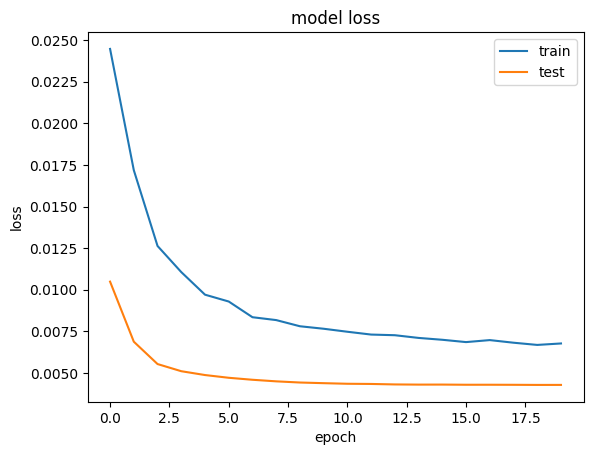

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_x[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

2874/2874 [==============================] - 7s 2ms/step
Test RMSE: 10.618


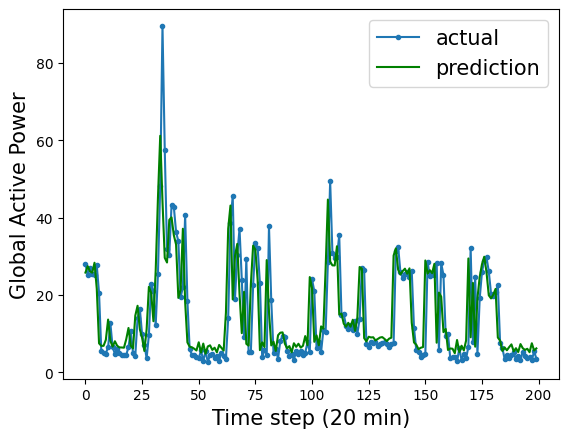

In [ ]:
aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'g', label="prediction")
plt.ylabel('Global Active Power', size=15)
plt.xlabel('Time step (20 min)', size=15)
plt.legend(fontsize=15)
plt.show()

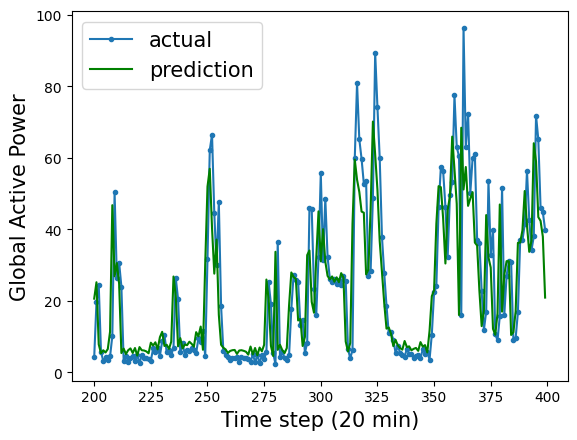

In [ ]:
aa=[x for x in range(200, 400)]
plt.plot(aa, inv_y[200:400], marker='.', label="actual")
plt.plot(aa, inv_yhat[200:400], 'g', label="prediction")
plt.ylabel('Global Active Power', size=15)
plt.xlabel('Time step (20 min)', size=15)
plt.legend(fontsize=15)
plt.show()